In [4]:
%pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
annotated-types              0.7.0
anyio                        4.4.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
bcrypt                       4.1.3
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.3
certifi                      2024.6.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
dnspython                    2.6.1

Working Dir:  /www/wwwroot/sewez/runtime/logoDetector
Dataset Dir:  /www/wwwroot/sewez/runtime/logoDetector/Datasets
Instructions for updating:
Use fn_output_signature instead
Loading weights from:  /www/wwwroot/sewez/runtime/logoDetector/model.h5


2024-06-21 03:24:40.728802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Processing 1 images
image                    shape: (1080, 1080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2024-06-21 03:24:42.948094: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_detection/Reshape_1' id:6831 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection/packed, mrcnn_detection/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


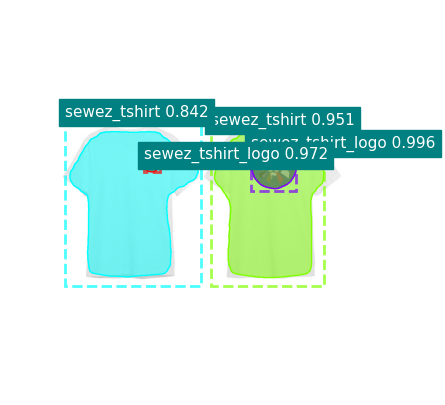

0.1513859275053305
0.1440162271805274
[{'tshirt': {'id': 1, 'score': 0.9513955, 'dimension': {'x': 324, 'y': 469, 'area': 151956, 'maskArea': 102820}, 'roi': [309, 563, 778, 887], 'dimensionCM': {'x': 49.049040511727085, 'y': 71, 'area': 3482.481876332623, 'maskArea': 2356.3978159764692}}, 'logos': [{'id': 2, 'score': 0.9958526, 'dimension': {'x': 130, 'y': 133, 'area': 17290, 'maskArea': 12352}, 'roi': [375, 678, 508, 808], 'dimensionCM': {'x': 19.680170575692966, 'y': 20.134328358208958, 'area': 396.2470165165644, 'maskArea': 283.07941862421075}}]}, {'tshirt': {'id': 1, 'score': 0.8419556, 'dimension': {'x': 389, 'y': 493, 'area': 191777, 'maskArea': 104617}, 'roi': [286, 146, 779, 535], 'dimensionCM': {'x': 56.022312373225155, 'y': 71, 'area': 3977.584178498986, 'maskArea': 2169.827059564121}}, 'logos': [{'id': 2, 'score': 0.9715499, 'dimension': {'x': 47, 'y': 46, 'area': 2162, 'maskArea': 1719}, 'roi': [408, 372, 454, 419], 'dimensionCM': {'x': 6.768762677484788, 'y': 6.6247464503

In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

graph = tf.compat.v1.get_default_graph()
LOGO_DETECT_ROOT_DIR = os.getcwd()
# LOGO_DETECT_ROOT_DIR = os.path.join(LOGO_DETECT_ROOT_DIR, 'runtime/logoDetector/')
LOGO_DETECT_ROOT_DIR = os.path.normpath(LOGO_DETECT_ROOT_DIR)
print("Working Dir: ", LOGO_DETECT_ROOT_DIR)

LOGO_DETECT_DATASET_DIR = os.path.join(LOGO_DETECT_ROOT_DIR, 'Datasets/')
LOGO_DETECT_DATASET_DIR = os.path.normpath(LOGO_DETECT_DATASET_DIR)
print("Dataset Dir: ", LOGO_DETECT_DATASET_DIR)

LOGO_DETECT_LOGS_DIR = os.path.join(LOGO_DETECT_ROOT_DIR, "trainingLogs")
MODEL_PATH = os.path.join(LOGO_DETECT_ROOT_DIR, 'model.h5')

LOGO_DETECT_GENERATED_PATH = os.path.join(LOGO_DETECT_ROOT_DIR, 'static/generated/order/')
# COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "LogoDetectorModel/preTrainedModel/mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(LOGO_DETECT_ROOT_DIR, "LogoDetectorModel/trainingLogs/sewez20240618T0707/trainingLogs")


class TrainingConfig(Config):
    NAME = "sewez"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 3
    STEPS_PER_EPOCH = 5
    DETECTION_MIN_CONFIDENCE = 0.9
    LEARNING_RATE = 0.001
class InferenceConfig(TrainingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", 
                        config=inference_config,
                        model_dir=LOGO_DETECT_LOGS_DIR)
print("Loading weights from: ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)
model.load_weights(MODEL_PATH, by_name=True,exclude=[
                    "mrcnn_class_logits", "mrcnn_bbox_fc",
                    "mrcnn_bbox", "mrcnn_mask"])
class TrainingDataset(utils.Dataset):

    def load_training_dataset(self, LOGO_DETECT_DATASET_DIR, subset):
        self.add_class("sewez", 1, "sewez_tshirt")
        self.add_class("sewez", 2, "sewez_tshirt_logo")
        self.add_class("sewez", 3, "sewez_tshirt_brand")
        assert subset in ["train", "val"]
        LOGO_DETECT_DATASET_DIR = os.path.join(LOGO_DETECT_DATASET_DIR, subset)
        annotations = json.load(open(os.path.join(LOGO_DETECT_DATASET_DIR, "annotation.json")))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            name_dict = {"sewez_tshirt": 1, "sewez_tshirt_logo": 2, "sewez_tshirt_brand": 3}
            num_ids = [name_dict[a] for a in objects]
            image_path = os.path.join(LOGO_DETECT_DATASET_DIR, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "sewez",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "sewez":
            return super(self.__class__, self).load_mask(image_id)
        info = self.image_info[image_id]
        if info["source"] != "sewez":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
# Training dataset.
dataset_train = TrainingDataset()
dataset_train.load_training_dataset(LOGO_DETECT_DATASET_DIR, "train")
dataset_train.prepare()
# Validation dataset
dataset_val = TrainingDataset()
dataset_val.load_training_dataset(LOGO_DETECT_DATASET_DIR, "val")
dataset_val.prepare()
#################################################################
#                    INFERENCE CODE                             #
#################################################################
def intersect(boxA, boxB):
    # Compute intersection rectangle coordinates
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[0], boxB[0])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[2], boxB[2])
    
    # Compute intersection area
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight
    
    return interArea > 0

def inferCalculateLogo(imagePath, savePath, model, dataset_val):
    # savePath = os.path.join(os.getcwd(), "static/generated/order", saveName)
    # logoPath = os.path.join(os.getcwd(), "static/uploads/order", logoName)
    # imagePath = "/www/wwwroot/sewez/runtime/logoDetector/Datasets/test/3.jpg"
    savePath1 = "/www/wwwroot/sewez/runtime/logoDetector/3.jpg"
    img = skimage.io.imread(imagePath)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5), save_path=savePath1)
    detection_result = []
    detected_tshirts = []
    detected_logos = []
    for rows, class_id in enumerate(r['class_ids']):
        detection_id = r['class_ids'][rows]
        detection_score = r['scores'][rows]
        detection_rois = r['rois'][rows].tolist()
        y1, x1, y2, x2 = r['rois'][rows]
        length = y2 - y1
        width = x2 - x1
        dimension = {
            "x": width,
            "y": length,
            "area": length * width,
            "maskArea": np.sum(r['masks'][:,:,rows])
            }
        detection = {
        "id": detection_id,
        "score": detection_score,
        "dimension": dimension,
        "roi": detection_rois,
        }
        detection_result.append(detection)
        if detection_id == 1:
            detected_tshirts.append(detection)
        elif detection_id == 2:
            detected_logos.append(detection)

    grouped_result = []
    for tShirt in detected_tshirts:
        # convert relative unit to cm
        tShirtHeightCM = 71
        ratioToCM = tShirtHeightCM/tShirt["dimension"]["y"]
        print(ratioToCM)
        tShirtWidthCM = ratioToCM * tShirt["dimension"]["x"]
        tShirtAreaCM = tShirtHeightCM * tShirtWidthCM
        tShirtMaskAreaCM = (ratioToCM**2) * tShirt["dimension"]["maskArea"]
        tShirt['dimensionCM'] = {
            "x": tShirtWidthCM,
            "y": tShirtHeightCM,
            "area": tShirtAreaCM,
            "maskArea": tShirtMaskAreaCM
        }
        # List to keep track of logos intersecting with the tshirt
        associated_logos = []
        for logo in detected_logos:
            if intersect(tShirt["roi"], logo["roi"]):
                # convert relative unit to cm
                logoHieghtCM = ratioToCM * logo["dimension"]["y"]
                logoWidthCM = ratioToCM * logo["dimension"]["x"]
                logoAreaCM = logoHieghtCM * logoWidthCM
                logoMaskAreaCM = (ratioToCM**2) * logo["dimension"]["maskArea"]
                logo["dimensionCM"] = {
                    "x": logoWidthCM,
                    "y": logoHieghtCM,
                    "area": logoAreaCM,
                    "maskArea": logoMaskAreaCM
                }
                associated_logos.append(logo)
        tshirt_with_logos = {
            "tshirt": tShirt,
            "logos": associated_logos
        }
        grouped_result.append(tshirt_with_logos)
    
    print(grouped_result)
    print("Terdeteksi", len(detected_tshirts), " Tshirt dan ", len(detected_logos), " Logo")
    detectionData = {
        "numberOfTshirt": len(detected_tshirts),
        "numberOfLogos": len(detected_logos),
        "data": grouped_result
    }   
    return detectionData

def calculateLogo(imagePath, savePath, model, dataset_val):
    # data = inferCalculateLogo(logoName=logoName, saveName=saveName, model=model, dataset_val=dataset_val)
    data = inferCalculateLogo(imagePath=imagePath, savePath=savePath, model=model, dataset_val=dataset_val)
    print(data)
    # logoData = data["data"]
    # logoReformat = []
    # for item in logoData:
    #     for logo in item['logos']:
    #         logoReformat.append({
    #             "x": logo['dimensionCM']['x'],
    #             "y": logo['dimensionCM']['y']
    #         })
    return {
        "error": False,
        "message": "Successfully calculated logo",
        "data": {
            # "logo": logoReformat,
            "image": savePath
        }
    }
#################################################################

print (calculateLogo(imagePath="/www/wwwroot/sewez/runtime/logoDetector/Datasets/test/2.jpg", savePath="/www/wwwroot/sewez/runtime/logoDetector/Datasets/2.jpg", model=model, dataset_val=dataset_val))

In [12]:
from typing import Union, Annotated
from fastapi import FastAPI, Response, Request, status, UploadFile, File, Header, Form
from fastapi.staticfiles import StaticFiles

app = FastAPI()

@app.get("/test/random")
def test(request: Request, response: Response):
    return calculateLogo(imagePath="/www/wwwroot/sewez/runtime/logoDetector/Datasets/test/2.jpg", savePath="/www/wwwroot/sewez/runtime/logoDetector/Datasets/2.jpg", model=model, dataset_val=dataset_val)

In [14]:
import asyncio
import uvicorn

if __name__ == "__main__":
    config = uvicorn.Config(app)
    server = uvicorn.Server(config)
    await server.serve()

INFO:     Started server process [10208]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Processing 1 images
image                    shape: (1080, 1080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


W0000 00:00:1718937862.043061   21335 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -48 } dim { size: -308 } dim { size: -309 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2299 num_cores: 4 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 2097152 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -19 } dim {

INFO:     103.161.109.150:0 - "GET /test/random HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/www/wwwroot/sewez/dev-env/lib/python3.10/site-packages/uvicorn/protocols/http/httptools_impl.py", line 399, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/www/wwwroot/sewez/dev-env/lib/python3.10/site-packages/uvicorn/middleware/proxy_headers.py", line 70, in __call__
    return await self.app(scope, receive, send)
  File "/www/wwwroot/sewez/dev-env/lib/python3.10/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/www/wwwroot/sewez/dev-env/lib/python3.10/site-packages/starlette/applications.py", line 123, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/www/wwwroot/sewez/dev-env/lib/python3.10/site-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/www/wwwroot/sewez/dev-env/lib/python3.10/site-packages/starlette/middleware/errors.py", line 

: 